In [1]:
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
import random
import matplotlib.animation
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
import matplotlib.pyplot as plt
from numba import jit
from tabulate import tabulate

In [2]:
@jit
def model(t, X, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω):
    
    N_n = X[0]
    N_r = X[1]
    P_U = X[2] #Susceptible Hosts
    P_I = X[3] #Infected Hosts
    Z   = X[4] #Zooplankton
    V_I = X[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
    V_E = X[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    if V_I == 0:  ν_i = 0 #avoid divison by 0 when evaluating ν_i
        
    else:
        ν_i = V_I / ((beta / alpha) * P_I + V_I)
        
    P = P_U + P_I
    
    N = N_n + N_r
    
    nutr_lim = N / (K_N + N)
     
    if N == 0: N = 1 #avoid divison by 0 when evaluating nutrient ratios

    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #light limitation term
    
    
    #Defining scaling factors depending on values of state variables
    thresh = 1e-8
    
    P_U_scale = 1
    if P_U < thresh:
        P_U_scale = P_U / thresh 
       
    P_I_scale = 1
    if P_I < thresh:
        P_I_scale = P_I / thresh

    Z_scale = 1 
    if Z < thresh:
        Z_scale = Z / thresh

    V_I_scale = 1
    if V_I < thresh:
        V_I_scale = V_I / thresh  
    
    V_E_scale = 1
    if V_E < thresh:
        V_E_scale = V_E / thresh   
        
        
    #Phytoplankton uninfected
    P_U_growth = P_U_scale * (P_U + P_I_scale * μ_u * P_I) * V_max * nutr_lim * light_lim
    
    P_U_grazing   = P_U * g * Z_scale * Z / K_P
    P_U_mortality = P_U * λ_P
    P_U_adsorp    = P_I_scale * P_U * (1 - ν_x) * φ * μ_s * V_E
    P_U_entrain   = P_U * ω
    
    P_U_dt = P_U_growth - P_U_grazing - P_U_mortality - P_U_adsorp - P_U_entrain
    
    
    #Phytoplankton infected
    P_I_adsorp       = P_I_scale * (1 - ν_x) * φ * μ_s * P_U * V_E
    P_I_growth       = P_I_scale * (1 - P_U_scale * μ_u) * P_I * V_max * nutr_lim * light_lim
    
    P_I_grazing      = P_I * g * Z_scale * Z / K_P
    P_I_mortality    = P_I * λ_P
    P_I_nt_recycling = V_I_scale * P_I * ν_i * μ_V
    P_I_lysis        = P_I * ν_i * δ
    P_I_entrain      = P_I * ω
    
    P_I_dt = P_I_adsorp + P_I_growth - P_I_grazing - P_I_mortality \
             - P_I_nt_recycling - P_I_lysis - P_I_entrain
    
    
    #Zooplankton
    Z_assimilation = Z_scale * Z * γ_Z * g * (P + V_I) / K_P
    Z_mortality    = Z * (λ_Z + λ_Z_hat * Z)
    Z_entrain      = Z * ω

    Z_dt = Z_assimilation - Z_mortality - Z_entrain
    
    
    #Intracellular viruses
    V_I_growth  = V_I_scale * ν_i * (beta / alpha) * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_adsorp  = V_I_scale * ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    
    V_I_lysis   = V_E_scale * V_I * ν_i * δ
    V_I_grazing = V_I * g * Z_scale * Z / K_P
    V_I_h_mort  = V_E_scale * V_I * λ_P
    V_I_entrain = V_I * ω
    
    V_I_dt = V_I_adsorp + V_I_growth - V_I_lysis - V_I_grazing - V_I_h_mort - V_I_entrain
    
    
    #Extracellular
    V_E_h_mort = V_E_scale * V_I * μ_r * λ_P

    V_E_mortality = λ_E * V_E
    V_E_adsorp    = V_I_scale * ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_E_entrain   = V_E * ω
    
    V_E_dt = - V_E_adsorp + V_I_lysis + V_E_h_mort - V_E_mortality - V_E_entrain
    
    
    #Nitrate
    N_n_accum     = (N_n / N) * (P_U_growth + P_I_growth)
    N_n_intracell = V_I_scale * (N_n / N) * ν_i * P_I * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_n_entrain   = ω * N_n 
    
    N_n_dt = - N_n_accum - N_n_intracell - N_n_entrain
            
        
    #Recycled nutrients
    N_r_accum        = (N_r / N) * (P_U_growth + P_I_growth)
    
    nt_recycling     = ν_i * P_I * (1 - (beta / alpha)) * μ_V
    denovo_syn       = ν_i * P_I * (N_r / N) * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_r_intracell    = V_I_scale * nt_recycling - denovo_syn
    
    N_r_mortality    = λ_P * (P + V_E_scale * (1 - μ_r) * V_I)
    N_r_Ve_mort      = λ_E * V_E
    N_r_lysis        = ν_i * δ * P_I
    N_r_sloppy_munch = (1 - γ_Z) * g * Z_scale * Z * (P + V_I) / K_P
    N_r_entrain      = N_r * ω
    
    N_r_remin  = (μ_P * N_r_mortality) + N_r_Ve_mort + (μ_delta * N_r_lysis) \
             + (μ_g * N_r_sloppy_munch) + (μ_Z * Z_mortality) - N_r_entrain

    N_r_export = (1 - μ_P) * N_r_mortality + (1 - μ_delta) * N_r_lysis \
             + (1 - μ_g) * N_r_sloppy_munch + (1 - μ_Z) * Z_mortality
    
    N_r_dt = - N_r_accum + N_r_intracell + N_r_remin + N_r_export
            
    
    return N_n_dt, N_r_dt, P_U_dt, P_I_dt, Z_dt, V_I_dt, V_E_dt


**Integrating model with intention to recreate Thamatrakoln results**

In [ ]:
#Inital Conditions
alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

Nn_0 = 1e20
Nr_0 = 1e20
Ps_0 = 1.5e14 * alpha 
Pi_0 = 1e5    * alpha #approx 1e-7 mmol / m^3
Z_0  = 0
Vi_0 = 1e8    * beta #approx 1e-7 mmol / m^3
Ve_0 = 2.7e12 * beta

z0 = [Nn_0, Nr_0, Ps_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = .85             # Maximum phytoplankton growth rate, Fig. 3 (a), irradience 300
γ_Z       = 0               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta  # Converted viral adsorption rate
g         = 0               # Maximum specific grazing rate

V_ind     = 4e5      #NT per individual virus, Table S1
S_ind     = 1.42e8   #NT per individual host, Table S1
ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair

λ_P       = 0   # Mortality & Respiration rate
λ_Z       = 0   # Linear mortality & respiration & egestion
λ_Z_hat   = 0   # Quadratic mortality & respiration & egestion
λ_E       = 0   # Mortality 
δ         = .45 # Host lysis rate


μ_V       = 3   # Max host NT recycling rate 
μ_V_prime = 1.6 # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0
μ_s       = 1
μ_P       = 0   # Remineralization fraction due to mortality
μ_delta   = 0   # Remineralization fraction due to lysis
μ_g       = 0   # Remineralization fraction due to sloppy-eating
μ_Z       = 0   # Remineralization fraction due to mortality

K_N       = 1          # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 1          # Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param = (V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω)

In [ ]:
#Time in days
t  = [0, 25]

#Solving for Solution
sol = solve_ivp(model, t, z0, args=param, max_step=.01, method="Radau")

In [ ]:
#Plot results
N_n = sol.y[0]
N_r = sol.y[1] 
P_U = sol.y[2] #Susceptible Hosts
P_I = sol.y[3] #Infected Hosts
Z   = sol.y[4] #Zooplankton
V_I = sol.y[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
V_E = sol.y[6] #Free (extracellular) viruses 
    
    
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.plot(sol.t, N_n, label='N_n')
ax.plot(sol.t, N_r, label='N_r')
ax.plot(sol.t, P_U / alpha, 'g', label='Susceptible')
ax.plot(sol.t, P_I / alpha, 'b', label='Infected')
ax.plot(sol.t, Z, label='Z')
ax.plot(sol.t, V_I / beta, '-', label='Total Intracellular V')
ax.plot(sol.t, V_E / beta, ':', label='Extracellular V')

ax.set_xlabel('Time (Days)', fontsize = 14)
ax.set_ylabel('Nucleotides ml^-1', fontsize = 14)
ax.set_title('Species dynamics over 2 weeks', fontsize = 14)

ax.set_ylim(-.01, 1e15)
ax.legend(loc=(1.025, .25))
ax.grid()


ax2.plot(sol.t, N_n + N_r + (P_U / alpha) + (P_I / alpha) + Z + (V_I / beta) + (V_E / beta))
ax2.set_xlabel('Time (Days)', fontsize = 14)
ax2.set_ylabel('Nucleotides ml^-1', fontsize = 14)
ax2.set_title('Total N', fontsize = 14)
ax2.grid()

fig.tight_layout()
plt.show()

**Model integration recreating Sarmiento and Gruber N-P-Z**

In [ ]:
#Inital Conditions
Nn_0 = 0  #mmol m^-3
Nr_0 = 5  #mmol m^-3
Ps_0 = .6 #mmol m^-3 
Pi_0 = 0
Z_0  = .6 #mmol m^-3
Vi_0 = 0
Ve_0 = 0

z0 = [Nn_0, Nr_0, Ps_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = 1.4 # Maximum phytoplankton growth rate, Fig. 3 (a), irradience 300
γ_Z       = .4  # Growth rate / Assimilation frequency 
φ         = 0   # Viral adsorption rate, ml / (NT * day), Table S1
g         = 1.4 # d^-1 Maximum specific grazing rate

#Irrelevant but included for consistancy
V_ind     = 4e5      # NT per individual virus, Table S1
S_ind     = 1.42e8   # NT per individual host, Table S1

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair

λ_P       = .05 # Mortality & Respiration rate
λ_Z       = .05 # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = .1   # Quadratic mortality & respiration & egestion
λ_E       = 0   # Extracellular virus mortality 
δ         = 0   # Host lysis rate

μ_V       = 0   # Max host NT recycling rate 
μ_V_prime = 0   # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0
μ_s       = 1
μ_P       = .4   # Remineralization fraction due to mortality
μ_delta   = 0   # Remineralization fraction due to lysis
μ_g       = .4   # Remineralization fraction due to sloppy-eating
μ_Z       = .4   # Remineralization fraction due to mortality

K_N       = .1  # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1   # Half-saturation for light limitation
K_h       = 1   # Half-saturation for ... ?
K_P       = 2.8 # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param = (V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω)

In [ ]:
sol = solve_ivp(model, [0, 26], z0, args=param, max_step=.1, method="LSODA")
cycle = solve_ivp(model, [0, 5475], z0, args=param, max_step = .1, method="LSODA")

In [ ]:
#Plot results
N_n = sol.y[0]
N_r = sol.y[1] 
P_U = sol.y[2] #Susceptible Hosts
P_I = sol.y[3] #Infected Hosts
Z   = sol.y[4] #Zooplankton
V_I = sol.y[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
V_E = sol.y[6] #Free (extracellular) viruses 

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

#One cycle
ax.plot(sol.t, P_U, label='Susceptible Phytoplankton')
ax.plot(sol.t, P_I, label='Infected Phytoplankton')
ax.plot(sol.t, Z,   label='Zooplanton')
ax.plot(sol.t, V_I, label='Intracellular Virus')
ax.plot(sol.t, V_E, label='Extracellular Virus')
ax.plot(sol.t, N_n, label='Nitrate')
ax.plot(sol.t, N_r, label='Recycled Nutrients')

ax.plot(sol.t, N_n + N_r + P_U + P_I + Z + V_I + V_E, 'g', label='Total sum')
#ax.set_ylim(0, .005)
ax.set_xlabel('Time (Day)', fontsize = 12)
ax.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax.set_title('Nutrients per population - one period (approx 25 days)',fontsize = 14)
ax.legend()
ax.grid()

#Three Cycles
ax2.plot(cycle.t, cycle.y[0] + cycle.y[1], 'b', linewidth= 2, label='Nutrient Supply')
ax2.plot(cycle.t, cycle.y[2], 'g:', linewidth = 2, label='Phytoplankton Pop-density')
ax2.plot(cycle.t, cycle.y[4], 'r--', linewidth = 2, label='Zooplanton Pop-density')

ax2.set_xlabel('Time (Day)', fontsize = 12)
ax2.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax2.set_title('Nutrients per population (15 years)', fontsize = 14)
ax2.legend()
ax2.grid()

cycle_tot = cycle.y[0]+cycle.y[1]+cycle.y[2]+cycle.y[3]+cycle.y[4]+cycle.y[5]+cycle.y[6]
ax3.plot(cycle.t, cycle_tot, 'g', label='Total sum')
ax3.set_xlabel('Time (Day)', fontsize = 12)
ax3.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax3.set_title('Nutrients per population (15 years)', fontsize = 14)
ax3.legend()
ax3.grid()

fig.tight_layout()
plt.show()

**Full Model Run, with coupled parameter inputs**

In [3]:
#Estimating viral abundance based off ratio of host to viral entitiy

def est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind):
    
    """
    r     (int)  : 1:r ratio of phytoplankton to viral enities
    Pu_0  (float): condition defining initial uninfected phytoplankton abundance
    alpha (float): conversion term for host related variables
    beta  (float): conversion term for virus related variables
    S_ind (float): Nucleotides per individual host
    V_ind (float): Nucleotides per individual virus
    """
    
    S_i = Pu_0 / alpha / S_ind  #individual hosts per ml
    
    V_est = r * S_i * V_ind * beta #mmol N / m^3
    
    return V_est

In [27]:
#Inital Conditions
alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

Nn_0 = 0    #mmol m^-3
Nr_0 = .0645    #mmol m^-3  #should keep Nr_0 above 1, for perturbation tests
Pu_0 = 1e-7 #mmol m^-3 
Pi_0 = 1e-7 #mmol m^-3
Z_0  = 1e-7 #mmol m^-3
Vi_0 = 1e-7 #mmol m^-3

# r = 10
# Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)

Ve_0 = 1e-7

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) 
                       # Proportion of nutrients originating 
                       # from virus in host-virus pair

λ_P       = .05        # Mortality & Respiration rate
λ_Z       = .05        # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = .1         # Quadratic mortality & respiration & egestion
λ_E       = .05        # ARBITRARY VALUE: Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARY VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [28]:
#Print parameterization and initial conditions
param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

table = np.empty((5,5), dtype=object)
i = 0

for col in range(5):
    for row in range(5):
        
        table[row][col] = f"{param_labels_fp[i]} = {round(param[i], 4)}"
        i += 1
        
#names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', f'For r = {r}, Ve_0']
names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', 'Ve_0']
for i, state in enumerate(names):
    print(f'{state} = {z0[i]}', end='  ')

print()
print()
print(tabulate(table, tablefmt='fancy_grid'))

Nn_0 = 0  Nr_0 = 0.0645  Pu_0 = 1e-07  Pi_0 = 1e-07  Z_0 = 1e-07  Vi_0 = 1e-07  Ve_0 = 1e-07  

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0.1 │ μ_u = 0         │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.05    │ μ_r = 0         │ μ_Z = 0.4     │

In [29]:
t = 1000
full = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')

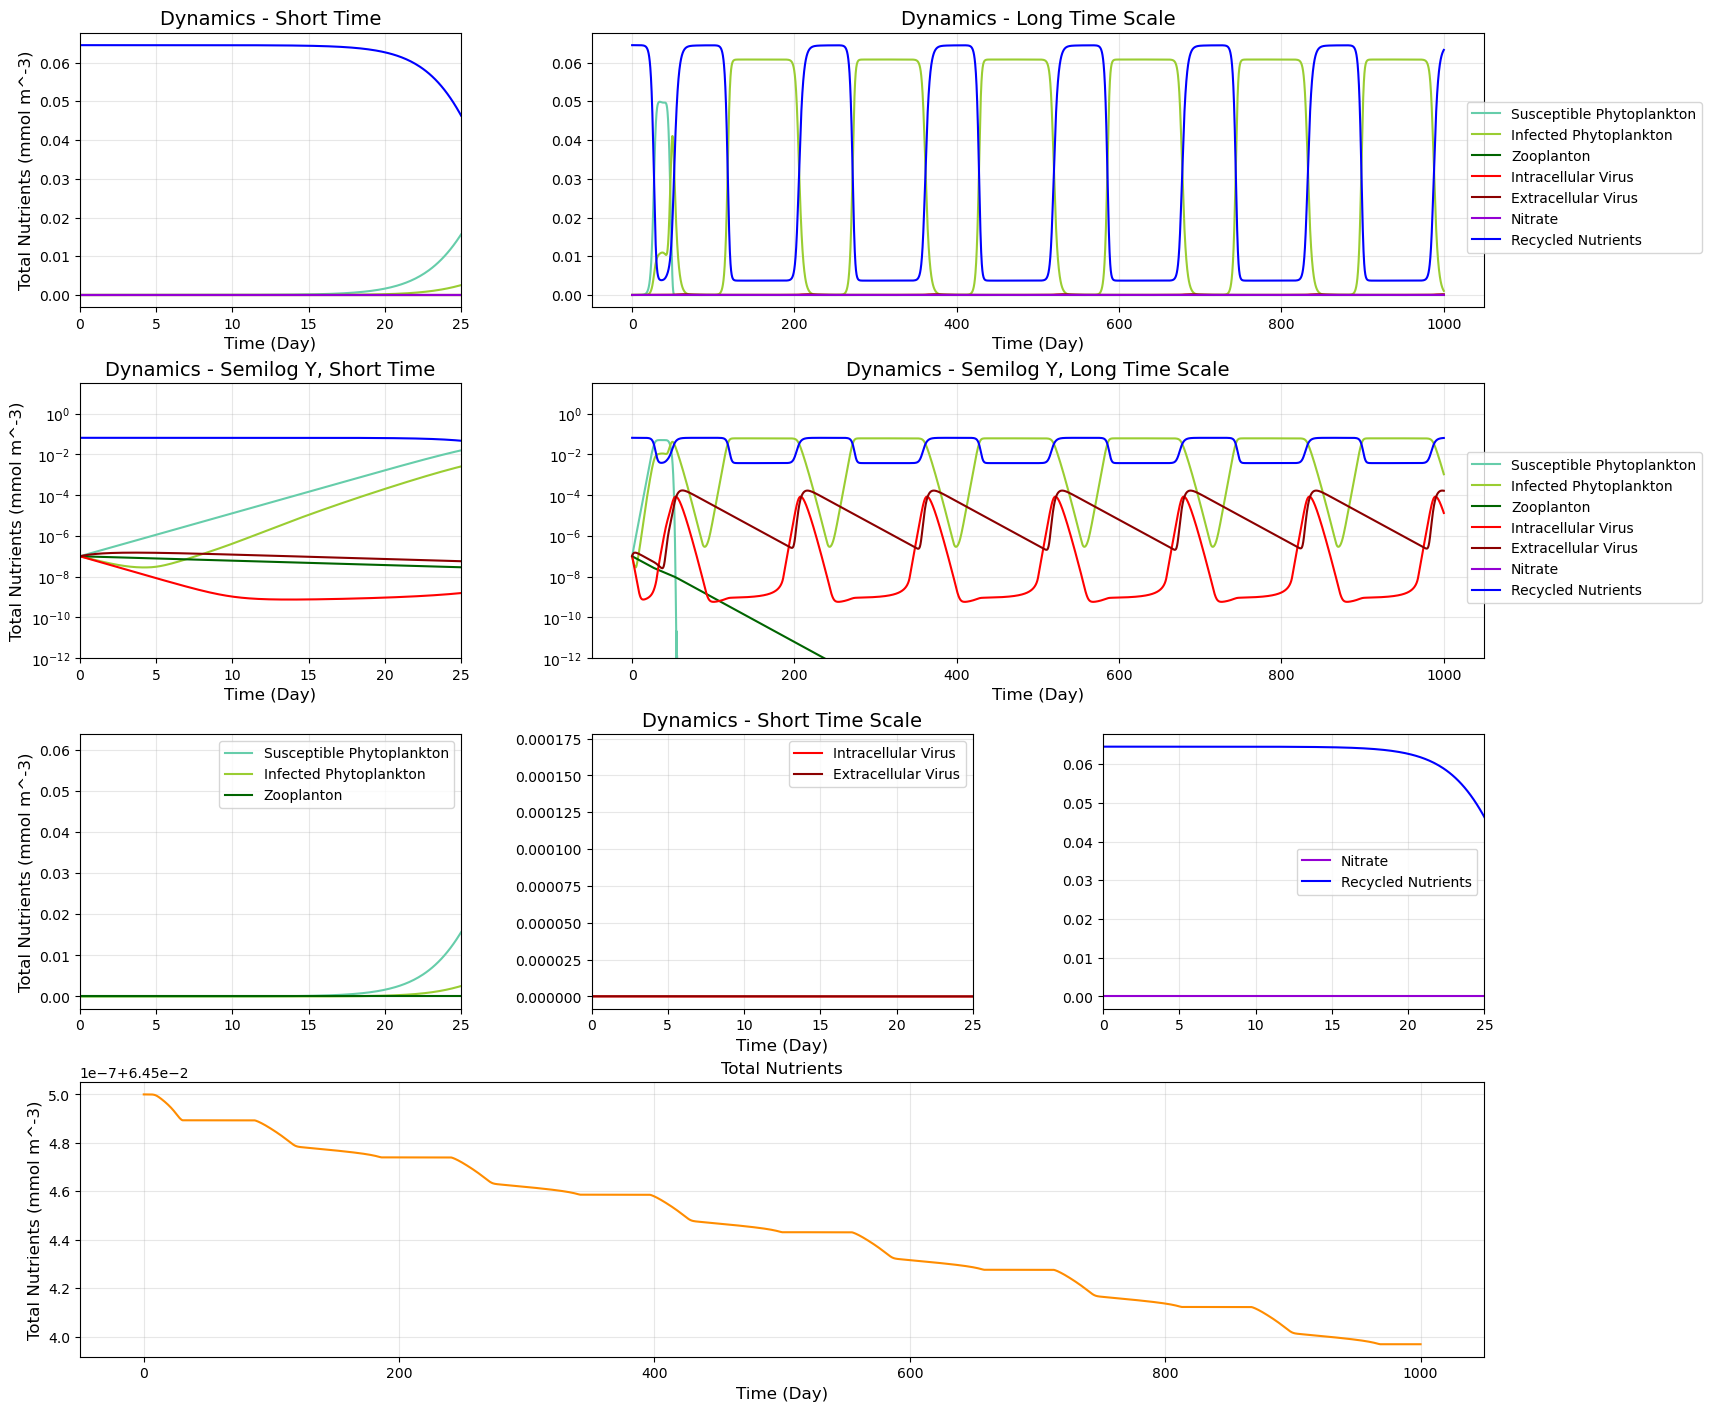

In [30]:
#Plot results
%matplotlib inline

N_n = full.y[0]
N_r = full.y[1] 
P_U = full.y[2] #Susceptible Hosts
P_I = full.y[3] #Infected Hosts
Z   = full.y[4] #Zooplankton
V_I = full.y[5] #Internal viruses from host nucleotide recycling 
                #and de novo nucleotide synthesis
V_E = full.y[6] #Free (extracellular) viruses 

short_scale_cutoff = 25
long_scale_cutoff = 5000 * .9

fig = plt.figure(layout="constrained", figsize = (17, 14))
ax = fig.subplot_mosaic(
        """
        ABB
        CDD
        EFG
        HHH
        """)
###
ax["A"].plot(full.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax["A"].plot(full.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["A"].plot(full.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["A"].plot(full.t, V_I, color="red"             , label='Intracellular Virus')
ax["A"].plot(full.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["A"].plot(full.t, N_n, color="darkviolet"      , label='Nitrate')
ax["A"].plot(full.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["A"].set_xlabel('Time (Day)', fontsize = 12)
ax["A"].set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax["A"].set_title('Dynamics - Short Time',fontsize = 14)

ax["A"].set_xlim(0, short_scale_cutoff)
#ax["A"].set_xlim(long_scale_cutoff, 5000)

###
ax["B"].plot(full.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax["B"].plot(full.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["B"].plot(full.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["B"].plot(full.t, V_I, color="red"             , label='Intracellular Virus')
ax["B"].plot(full.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["B"].plot(full.t, N_n, color="darkviolet"      , label='Nitrate')
ax["B"].plot(full.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["B"].set_xlabel('Time (Day)', fontsize = 12)
ax["B"].set_title('Dynamics - Long Time Scale',fontsize = 14)

###
ax["C"].plot(full.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax["C"].plot(full.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["C"].plot(full.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["C"].plot(full.t, V_I, color="red"             , label='Intracellular Virus')
ax["C"].plot(full.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["C"].plot(full.t, N_n, color="darkviolet"      , label='Nitrate')
ax["C"].plot(full.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["C"].set_xlabel('Time (Day)', fontsize = 12)
ax["C"].set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax["C"].set_title('Dynamics - Semilog Y, Short Time',fontsize = 14)

ax["C"].set_yscale('log')
ax["C"].set_ylim(1e-12, 30)
ax["C"].set_xlim(0, short_scale_cutoff)
#ax["C"].set_xlim(long_scale_cutoff, 5000)

###
ax["D"].plot(full.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax["D"].plot(full.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["D"].plot(full.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["D"].plot(full.t, V_I, color="red"             , label='Intracellular Virus')
ax["D"].plot(full.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["D"].plot(full.t, N_n, color="darkviolet"      , label='Nitrate')
ax["D"].plot(full.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["D"].set_xlabel('Time (Day)', fontsize = 12)
ax["D"].set_title('Dynamics - Semilog Y, Long Time Scale',fontsize = 14)

ax["D"].set_yscale('log')
ax["D"].set_ylim(1e-12, 30)

###
ax["E"].plot(full.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax["E"].plot(full.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["E"].plot(full.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["F"].plot(full.t, V_I, color="red"             , label='Intracellular Virus')
ax["F"].plot(full.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["G"].plot(full.t, N_n, color="darkviolet"      , label='Nitrate')
ax["G"].plot(full.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["F"].set_xlabel('Time (Day)', fontsize = 12)
ax["E"].set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax["F"].set_title('Dynamics - Short Time Scale',fontsize = 14)

for plot in ("E", "F", "G"):
    ax[plot].legend()
    ax[plot].set_xlim(0, short_scale_cutoff)
    #ax[plot].set_xlim(long_scale_cutoff, 5000)
    
###
ax["H"].plot(full.t, N_n + N_r + P_U + P_I + Z + V_I + V_E, color ='darkorange', label='Total sum')

# nu_i = []
# for i in range(len(full.t)):
#     if P_I[i] == 0 and V_I[i] == 0:  nu_i.append(0)
        
#     else:
#         nu_i.append((V_I[i] / beta) / ((P_I[i] / alpha) + (V_I[i] / beta)))

# ax["H"].plot(full.t, nu_i, label='ν_i')
# ax["H"].set_ylim(-.1, 1.1)

ax["H"].set_xlabel('Time (Day)', fontsize = 12)
ax["H"].set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax["H"].set_title('Total Nutrients')
#ax["H"].set_title('ν_i', fontsize=14)

###
ax["B"].legend(loc=(.98, .2)), ax["D"].legend(loc=(.98, .2))

for plot in ax:
    ax[plot].grid(alpha=.3)

In [31]:
%store full

Stored 'full' (OdeResult)


**Change in model shape for different parameter and state initial values**

In [ ]:
def structure(t_max):
    'Computes the difference (days) between each consecutive infected pyhtoplankton peak'
    
    l = len(t_max)
    periods = []
    
    if l > 1:
        for i in range(l - 1):
            periods.append(t_max[i + 1] - t_max[i])
    else:
        periods = ["NA"]
    
    return periods

In [ ]:
#Integrate for each value of specified NON-STATE variable
varied_var = 'μ_V' 
num = 5
t = 500
#varied_values = np.linspace(0, 1, num)
varied_values = [1, 1.1, 1.11, 1.15, 1.25]
#varied_values = [1.4, 1.45, 1.47, 1.476, 1.65]


sols = []

for i, val in enumerate(varied_values):
    ind = param_labels.index(varied_var)
    param[ind] = val #redefines specified value in the initial conditions
    
    # Using brute force 
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-5, max_step = .1, method = 'LSODA')   
    
#     if solution.status == -1:
#         solution = solve_ivp(model, [0, t], z0, args=param, max_step = .1, method = "DOP853") 
        
    sols.append(solution)

In [ ]:
#Integrate for each value of specified STATE variable

varied_var = 'N_r' 
num = 400
t = 200

#varied_values = np.linspace(0, 2, num) #Start at > 0 if running perturbations
varied_values = np.logspace(-2, 3, num) * 2e-3

sols = []

for i, val in enumerate(varied_values):
    #Redifines initial state conditions
    #SET STATE VAR INDEX
    z0[1] = val
    
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
    sols.append(solution)

In [ ]:
#Dual varying 

# varied_var = 'μ_V' 
# num = 5
# t = 6000

# varied_values = np.linspace(1, 1.7, num)
# varied_total_N  = np.arange(0, 20, .1)

# sols = [[] for i in range(len(varied_values))]

# for i, val in enumerate(varied_values):
    
#     for j, total in enumerate(varied_total_N):
#         #Redifines initial state conditions
#         #SET STATE VAR INDEX
#         z0[1] = total
        
#         #redefines specified value in the initial conditions
#         ind = param_labels.index(varied_var)
#         param[ind] = val 

#         solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
#         sols[i].append(solution)

In [ ]:
#Initial conditions based off total N

sols = []
t_span = 250

#Defining Ranges
N_r_range = np.linspace(1e-7, 20, 5)
P_U_range = np.linspace(1e-7, 20, 5)
Z_range   = np.linspace(1e-7, 20, 5)
V_e_range = np.logspace(0, 1.5, 5)    #range of r for 1/r ratio of host to viruses

Pi_0 = 1e-7
Vi_0 = 1e-7

count = 0 #count how many solutions meet qualifications

for Nr_0 in N_r_range:
    for Pu_0 in P_U_range:
        for Z_0 in Z_range:
            for r in V_e_range:
                
                Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)
                
                z0 = [0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
                
                if sum(z0) > 25: #If the combination of initial state values
                    continue     #is greater than the maximum allowable total N,
                                 #then move to next combination
                count += 1
                #print(f'{count:<3} N_t = {sum(z0):<8.2} Nr_0: {Nr_0:<7.2} Pu_0: {Pu_0:<7.2} Pi_0: {Pi_0:<7.2} Z_0: {Z_0:<7.2} Vi_0: {Vi_0:<7.2} Ve_0: {Ve_0:<7.2}')
                
                z0 = [0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
                
                solution = solve_ivp(model, [0, t_span], z0, args=param, 
                                     min_step = 1e-8, max_step = .1, method = 'LSODA')     
                
                sols.append(solution)
                
count

In [ ]:
#Latin Hypercube sampling for initial conditions
LHS = []

sampler = qmc.LatinHypercube(d=3)
sample = sampler.random(n=2)

#          [N_r, P_u, Z]
l_bounds = [0, 1e-7, 1e-7]
u_bounds = [20, 20, 20]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)


for l in sample_scaled:
    LHS.append([0, l[0], l[1], 0, l[2], 0, est_viral_abund(100, l[1], alpha, beta, S_ind, V_ind)])

for l in LHS:
    print(l)

In [ ]:
#Running simulations based on LH sampling
sols = []
t_span = 100

for initial_state in LHS:
    z0 = initial_state
    
    solution = solve_ivp(model, [0, t_span], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
    sols.append(solution)

**Testing Robusticity**

In [ ]:
#Not for large solution sets

pls_print = True
robust = {}
perturbed_sols = [[] for k in range(len(sols))]

for i, solution in enumerate(sols):
    
    z0[1] = varied_values[i] #making sure to vary total nooch levels
    
    if pls_print:
        plt.figure(figsize = (15, 2))
        plt.title(f'P_I solution for total N = {round(sum(z0), 5)}')
        plt.xlabel("Days")
        plt.ylabel("mmol N / m^3")
    
        sub = int(len(solution.t) * .95)
        plt.plot(solution.t[sub: ], solution.y[3][sub: ], label="Unperturbed")

    robust[i] = [] #Keys represent particular solution

    #Calculate new solution with perturbed intitial conditions
    print(f'Comparing perturbations of soluiton {i}...')
    
    for j in range(2): #number of randomly perturbed runs
        
        #generating appropriately sized perturbations based on initial condition levels
        perturb = np.array([0, 0, ])
        
        #disregarding N_n and N_r for now; use these quantities to balance mass later
        for k, val in enumerate(z0[2: ]): 
            
            #for some val = aeb, want 1e(b-1) <= pert <= 1eb
            b = int(math.log10(val)) #extract order of val
            
            sign = 1 if random.random() < .5 else -1  #generate random sign
            p = sign * random.uniform(10 ** (b-1), 10 ** b)  #generate random pert in desired range
            
            perturb = np.append(perturb, p)
            
        perturb[1] = -sum(perturb)  #mass balance by subtracting from N_r
        init = np.array(z0) + perturb  #redefine initital conditions with perturbations
        
        #Check for negative initial values
        if any(n < 0 for n in init): 
            print("Negative initial values; Beware!") 
            print(f"z0 = {init}")
            print()
            
#         if sum(perturb) != 0:
#             print("Perturbations do not add to zero.")
#             print(f"Sum of perturbations: {sum(perturb)}")
#             print()
        
        compare = solve_ivp(model, [0, t], init, args=param, min_step=1e-8, max_step = .1, method = 'LSODA')
        perturbed_sols[i].append(compare) #saving perturbed solutions for later
        
        if pls_print:
            sub = int(len(solution.t) * .95)
            plt.plot(compare.t[sub: ], compare.y[3][sub: ], label="Perturbed")
            plt.legend(loc=(1.02, .1))
            plt.grid(True, which="both")

        #Comparing distance of solutions 
        begin_ind = int(len(solution.t) * .9) #Finding index which partitions last 10% of data
        
        dist = []
        for point in compare.y[3][begin_ind: ]:
            d = abs(solution.y[3][-1] - point) #compare end of purturbed solution to initital solution
            dist.append(d)
        
        if len(dist) == 0:
            print("Integration Failed :(")
            print()
            continue
            
        robust[i].append(min(dist))
        
    print('Done!')

plt.show()

In [ ]:
robust

**Plotting Infected Plankton Curve**

In [ ]:
#Pull sources and sinks of Infected Phytoplankton from solutions above
P_I_svs = {"Adsorp":[], "Growth": [], "Grazing": [], "Mortality": [], "NT_recy": [], "Lysis": []}

for i, solution in enumerate(sols):
    
    N_n = solution.y[0]
    N_r = solution.y[1] 
    P_U = solution.y[2]
    P_I = solution.y[3]
    Z   = solution.y[4]
    V_I = solution.y[5]
    V_E = solution.y[6]
    
    N = N_n + N_r
    
    nutr_lim = N / (K_N + N)
    
    thresh = 1e-8
    l = len(solution.t)
    
    nu_i = []
    P_U_scale = [1] * l
    P_I_scale = [1] * l
    Z_scale   = [1] * l 
    V_I_scale = [1] * l
    
    for j in range(l):
        
        if P_U[j] < thresh:
            P_U_scale[j] = P_U[j] / thresh 
        
        if P_I[j] < thresh:
            P_I_scale[j] = P_I[j] / thresh
        
        if Z[j] < thresh:
            Z_scale[j] = Z[j] / thresh
        
        if V_I[j] < thresh:
            V_I_scale[j] = V_I[j] / thresh 

        if V_I[j] == 0:  nu_i.append(0)
        else:
            num = V_I[j] / ((beta * P_I[j] / alpha) + V_I[j])
            nu_i.append(num)

    P_U_scale = np.array(P_U_scale)
    P_I_scale = np.array(P_I_scale)
    Z_scale   = np.array(Z_scale) 
    V_I_scale = np.array(V_I_scale)
    nu_i = np.array(nu_i)
    
    ### Sans P_I coeffs, therefore dim = 1/day
    adsorp    = P_I_scale * (1 - ν_x) * φ * μ_s * P_U * V_E / P_I
    growth    = P_I_scale * (1 - P_U_scale * μ_u) * V_max * nutr_lim
    
    grazing   = g * Z_scale * Z / K_P
    mortality = np.full(l, λ_P)
    nt_recy   = V_I_scale * nu_i * μ_V
    lysis     = nu_i * δ
    
    P_I_svs["Adsorp"].append(adsorp)
    P_I_svs["Growth"].append(growth)
    P_I_svs["Grazing"].append(grazing)
    P_I_svs["Mortality"].append(mortality)
    P_I_svs["NT_recy"].append(nt_recy)
    P_I_svs["Lysis"].append(lysis)
    

In [ ]:
#Plotting full system, with enphasis on infected plankton 
fig, axs = plt.subplots(num, 1, constrained_layout=True, figsize=(15, 25))

for i, solution in enumerate(sols):
    l_max = argrelmax(solution.y[3])[0]
    t_max = [solution.t[i] for i in l_max]
    y_max = [solution.y[3][i] for i in l_max]

    per = structure(t_max)
    axs[i].plot(solution.t, solution.y[0], color="darkviolet"      , label='N_n', alpha = .3)
    axs[i].plot(solution.t, solution.y[1], color="blue"            , label='N_r', alpha = .3)
    axs[i].plot(solution.t, solution.y[2], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[i].plot(solution.t, solution.y[3], color="black"           , label='P_I')
    axs[i].plot(solution.t, solution.y[4], color="darkgreen"       , label='Z', alpha = .3)
    axs[i].plot(solution.t, solution.y[5], color="red"             , label='V_I', alpha = .3)
    axs[i].plot(solution.t, solution.y[6], color="darkred"         , label='V_E', alpha = .3)
    
    axs[i].text(1.01, .9, varied_var + f' = {round(varied_values[i], 8)}', 
                backgroundcolor='white', transform = axs[i].transAxes, fontsize = 12)
                
    axs[i].scatter(t_max, y_max, color = 'red', label = "Local Max")

    h = .75
    for j in range(len(per)):

        if j > 4: break

        if per[j] != 'NA':
            axs[i].text(1.11, h, f'P{j + 1}: {round(per[j], 3)}', 
                    backgroundcolor='white', transform = axs[i].transAxes)
            h -= .1

        else:
            axs[i].text(1.11, h, f'P{j + 1}: NA', 
                    backgroundcolor='white', transform = axs[i].transAxes)
            break
    
    #axs[i].plot(solution.t, np.full(len(solution.t), 1e-8), '--', color='lightgray')
    
    axs[i].set_xlabel('Time (Day)')
    axs[i].set_ylabel('mmol N / m^3')
    axs[0].set_title('Dynamics - Semilog Y, Long Time Scale',fontsize = 12)

    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-9, 1e2)
    axs[i].set_xlim(- t * .01, t * 1.01)
    axs[i].grid(alpha=.3); axs[i].legend(loc=(1.01, .1))



In [ ]:
#Plotting full system WITH small time scale
%matplotlib inline

fig, axs = plt.subplots(num, 2, figsize=(16, 30), width_ratios=[1, 2])


for i, solution in enumerate(sols):
    
    short_time = 1000
    axs[i][0].plot(solution.t[0: short_time], solution.y[0][0: short_time], color="darkviolet"      , label='N_n', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[1][0: short_time], color="blue"            , label='N_r', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[2][0: short_time], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[3][0: short_time], color="black"           , label='P_I')
    axs[i][0].plot(solution.t[0: short_time], solution.y[4][0: short_time], color="darkgreen"       , label='Z', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[5][0: short_time], color="red"             , label='V_I', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[6][0: short_time], color="darkred"         , label='V_E', alpha = .3)
    
    
    l_max = argrelmax(solution.y[3])[0]
    t_max = [solution.t[i] for i in l_max]
    y_max = [solution.y[3][i] for i in l_max]

    per = structure(t_max)
    axs[i][1].plot(solution.t, solution.y[0], color="darkviolet"      , label='N_n', alpha = .3)
    axs[i][1].plot(solution.t, solution.y[1], color="blue"            , label='N_r', alpha = .3)
    axs[i][1].plot(solution.t, solution.y[2], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[i][1].plot(solution.t, solution.y[3], color="black"           , label='P_I')
    axs[i][1].plot(solution.t, solution.y[4], color="darkgreen"       , label='Z', alpha = .3)
    axs[i][1].plot(solution.t, solution.y[5], color="red"             , label='V_I', alpha = .3)
    axs[i][1].plot(solution.t, solution.y[6], color="darkred"         , label='V_E', alpha = .3)
    
#     print(f'Steady state solution values for N_n(0) = {Nn_0} and N_r(0) = {varied_values[i]}')
#     print(f"N_n = {solution.y[0][-1]}")
#     print(f"N_r = {solution.y[1][-1]}")
#     print(f"P_U = {solution.y[2][-1]}")
#     print(f"P_I = {solution.y[3][-1]}")
#     print(f"Z   = {solution.y[4][-1]}")
#     print(f"V_I = {solution.y[5][-1]}")
#     print(f"V_E = {solution.y[6][-1]}")
#     print()
    
    
    axs[i][1].text(1.01, .9, varied_var + f'(0) = {round(varied_values[i], 8)}', 
                backgroundcolor='white', transform = axs[i][1].transAxes, fontsize = 12)
                
    #axs[i][1].scatter(t_max, y_max, color = 'red', label = "Local Max")

    h = .75
    for j in range(len(per)):

        if j > 7: break

        if per[j] != 'NA':
            axs[i][1].text(1.15, h, f'P{j + 1}: {round(per[j], 3)}', 
                    backgroundcolor='white', transform = axs[i][1].transAxes)
            h -= .1

        else:
            axs[i][1].text(1.15, h, f'P{j + 1}: NA', 
                    backgroundcolor='white', transform = axs[i][1].transAxes)
            break
    
    #axs[i].plot(solution.t, np.full(len(solution.t), 1e-8), '--', color='lightgray')
    
    
    axs[i][0].set_ylabel('mmol N / m^3')
    axs[i][0].set_xlabel('Time (Day)')
    axs[i][1].set_xlabel('Time (Day)')
    axs[0][1].set_title(f'Dynamics for N_n(0) = {Nn_0}',fontsize = 16)

    axs[i][1].set_yscale('log')
    axs[i][1].set_ylim(1e-9, 1e2)
    axs[i][1].set_xlim(- t * .01, t * 1.01)
    axs[i][0].grid(alpha=.3); axs[i][1].grid(alpha=.3); 
    axs[i][1].legend(loc=(1.01, 0))

    fig.tight_layout()


In [ ]:
#Plotting full system JUST small time scale
%matplotlib inline
fig, axs = plt.subplots(num, 2, figsize=(12, 20))

for i, solution in enumerate(sols):
    
    short_time = 500
    axs[i][0].plot(solution.t[0: short_time], solution.y[0][0: short_time], color="darkviolet"      , label='N_n', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[1][0: short_time], color="blue"            , label='N_r', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[2][0: short_time], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[3][0: short_time], color="black"           , label='P_I')
    axs[i][0].plot(solution.t[0: short_time], solution.y[4][0: short_time], color="darkgreen"       , label='Z', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[5][0: short_time], color="red"             , label='V_I', alpha = .3)
    axs[i][0].plot(solution.t[0: short_time], solution.y[6][0: short_time], color="darkred"         , label='V_E', alpha = .3)

    axs[i][0].set_ylabel('mmol N / m^3')
    axs[i][0].set_xlabel('Time (Day)')
    axs[i][0].set_title(f'Dynamics for Ve_0 = {round(varied_values[i], 8)}',fontsize = 12)

    axs[i][1].plot(solution.t[0: short_time], solution.y[0][0: short_time], color="darkviolet"      , label='N_n', alpha = .3)
    axs[i][1].plot(solution.t[0: short_time], solution.y[1][0: short_time], color="blue"            , label='N_r', alpha = .3)
    axs[i][1].plot(solution.t[0: short_time], solution.y[2][0: short_time], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[i][1].plot(solution.t[0: short_time], solution.y[3][0: short_time], color="black"           , label='P_I')
    axs[i][1].plot(solution.t[0: short_time], solution.y[4][0: short_time], color="darkgreen"       , label='Z', alpha = .3)
    axs[i][1].plot(solution.t[0: short_time], solution.y[5][0: short_time], color="red"             , label='V_I', alpha = .3)
    axs[i][1].plot(solution.t[0: short_time], solution.y[6][0: short_time], color="darkred"         , label='V_E', alpha = .3)

    axs[i][1].set_ylabel('mmol N / m^3')
    axs[i][1].set_xlabel('Time (Day)')
    axs[i][1].set_title(f'Dynamics for Ve_0 = {round(varied_values[i], 8)}',fontsize = 12)
    
    axs[i][1].set_yscale('log')
    axs[i][1].set_ylim(1e-9, 1e2)

    axs[i][1].grid(alpha=.3); axs[i][0].grid(alpha=.3); axs[i][1].grid(alpha=.3)
    
axs[-1][1].legend(loc=(1.01, 0))
fig.tight_layout()


In [ ]:
#Plotting full system w/ SOURCES and SINKS 
for i, solution in enumerate(sols):
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 6))
        
    l_max = argrelmax(solution.y[3])[0]
    t_max = [solution.t[i] for i in l_max]
    y_max = [solution.y[3][i] for i in l_max]

    per = structure(t_max)
    axs[0].plot(solution.t, solution.y[0], color="darkviolet"      , label='N_n', alpha = .3)
    axs[0].plot(solution.t, solution.y[1], color="blue"            , label='N_r', alpha = .3)
    axs[0].plot(solution.t, solution.y[2], color="mediumaquamarine", label='P_U', alpha = .3)
    axs[0].plot(solution.t, solution.y[3], color="black"           , label='P_I')
    axs[0].plot(solution.t, solution.y[4], color="darkgreen"       , label='Z', alpha = .3)
    axs[0].plot(solution.t, solution.y[5], color="red"             , label='V_I', alpha = .3)
    axs[0].plot(solution.t, solution.y[6], color="darkred"         , label='V_E', alpha = .3)

    axs[0].text(1.02, .9, varied_var + f'= {round(varied_values[i], 8)}', 
                backgroundcolor='white', transform = axs[0].transAxes, fontsize = 12)
                
#    axs[0].scatter(t_max, y_max, color = 'red', label = "Local Max")

#     h = .7
#     for j in range(len(per)):

#         if j > 2: break

#         if per[j] != 'NA':
#             axs[0].text(1.25, h, f'Period {j + 1}: {round(per[j], 3)} days', 
#                     backgroundcolor='white', transform = axs[0].transAxes)
#             h -= .1

#         else:
#             axs[0].text(1.25, h, f'Period {j + 1}: NA', 
#                     backgroundcolor='white', transform = axs[0].transAxes)
#             break
    
    axs[0].plot(solution.t, np.full(len(solution.t), 1e-8), '--', color='lightgray')
    
    axs[0].set_ylabel('mmol N / m^3')
    axs[0].set_title(f'Dynamics for N_n(0) = {Nn_0}',fontsize = 16)

    axs[0].set_yscale('log')
    axs[0].set_ylim(1e-9, 1e2)
    axs[0].set_xlim(- t * .01, t * 1.01)
    axs[0].grid(alpha=.3); axs[0].legend(loc=(1.02, 0))
    
    
    #calc and plot sources and sinks for P_I
    sources = P_I_svs["Adsorp"][i] + P_I_svs["Growth"][i]
    sinks = P_I_svs["Grazing"][i] + P_I_svs["Mortality"][i] \
            + P_I_svs["NT_recy"][i] + P_I_svs["Lysis"][i]
    
    axs[1].plot(solution.t, sources, label = 'Sources', color='black')
    axs[1].plot(solution.t, P_I_svs["Adsorp"][i], label = 'Adsorption', alpha = .5)
    axs[1].plot(solution.t, P_I_svs["Growth"][i], label='Growth', alpha = .5)
    
    axs[1].plot(solution.t, sinks, '--', color = 'black', label ='Sinks')
    axs[1].plot(solution.t, P_I_svs["Grazing"][i], '--', label='Grazing', alpha = .5)
    axs[1].plot(solution.t, P_I_svs["Mortality"][i], '--', label='Mortality', alpha = .5)
    axs[1].plot(solution.t, P_I_svs["NT_recy"][i], '--', label='NT Recycling', alpha = .5)
    axs[1].plot(solution.t, P_I_svs["Lysis"][i], '--', label='Lysis', alpha = .5)
    
    #axs[1].plot(solution.t, sources - sinks, label = 'P_I', color='red')
    
    #calc and plot sources and sinks for V_I
#     sources = V_I_svs["Growth"][i] + V_I_svs["Adsorp"][i]
#     sinks = V_I_svs["Grazing"][i] + V_I_svs["Lysis"][i] + V_I_svs["Host Mortality"][i]
    
#     axs[1].plot(solution.t, sources, label = 'Sources', color='black')
#     axs[1].plot(solution.t, V_I_svs["Adsorp"][i], label = 'Adsorption', alpha = .3)
#     axs[1].plot(solution.t, V_I_svs["Growth"][i], label='Growth', alpha = .3)
    
#     axs[1].plot(solution.t, sinks, '--', color = 'black', label ='Sinks')
#     axs[1].plot(solution.t, V_I_svs["Grazing"][i], '--', label='Grazing', alpha = .3)
#     axs[1].plot(solution.t, V_I_svs["Lysis"][i], '--', label='Lysis', alpha = .3)
#     axs[1].plot(solution.t, V_I_svs["Host Mortality"][i], '--', label='Mortality', alpha = .3)
    
    axs[1].set_xlabel('Time (Day)')
    axs[1].set_ylabel('per Day')
    axs[1].set_title('Sources vs. Sinks of P_I',fontsize = 12)

    axs[1].set_yscale('log')
    axs[1].set_ylim(1e-3, 1e1)
    axs[1].set_xlim(- t * .01, t * 1.01)
    axs[1].grid(alpha=.3); axs[1].legend(loc=(1.01, 0))
    
    fig.tight_layout(pad=2)
    

In [ ]:
#Animation of progression of solutions
%matplotlib tk

total_N_list = np.array([sum(solution.y[:, 0]) for solution in sols], dtype=object)

time = np.array([solution.t for solution in sols], dtype=object)

Nn = np.array([solution.y[0] for solution in sols], dtype=object)
Nr = np.array([solution.y[1] for solution in sols], dtype=object)
PU = np.array([solution.y[2] for solution in sols], dtype=object)
PI = np.array([solution.y[3] for solution in sols], dtype=object)
Z  = np.array([solution.y[4] for solution in sols], dtype=object)
VI = np.array([solution.y[5] for solution in sols], dtype=object)
VE = np.array([solution.y[6] for solution in sols], dtype=object)

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlim(0, t)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
    
    plt.subplots_adjust(top=.8, bottom=.15, left=.07)
    
    ax.text(0.09, 1.16, 
            f'Nn_0 = {z0[0]},  Nr_0 = {varied_values[i]:>6.5},  Pu_0 = {z0[2]},  Pi_0 = {z0[3]},  Z_0 = {z0[4]},  Vi_0 = {z0[5]},  Ve_0 = {z0[6]}', 
            fontsize=14, 
            transform=ax.transAxes)
    
    ax.plot(time[i], Nn[i], color="darkviolet"      ,label = "N_n")
    ax.plot(time[i], Nr[i], color="blue"            ,label = "N_r")
    ax.plot(time[i], PU[i], color="mediumaquamarine",label = "P_U")
    ax.plot(time[i], PI[i], color="limegreen"       ,label = "P_I")
    ax.plot(time[i], Z [i], color="darkgreen"       ,label = "Z ")
    ax.plot(time[i], VI[i], color="red"             ,label = "V_I")
    ax.plot(time[i], VE[i], color="darkred"         ,label = "V_E")

    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('Time (Day)',fontsize = 12)
    ax.set_ylabel('mmol N / m^3',fontsize = 12)

    ax.set_title(f'Dynamics for N_T = {total_N_list[i]:.5}',fontsize = 14)
    ax.set_yscale('log')
    ax.set_xlim(-t * .01, t * 1.01)
    ax.set_ylim(1e-9, 1e2)
    ax.grid(alpha=.3)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))



**Plotting ν_i over time**

In [ ]:
fig, axs = plt.subplots(1, constrained_layout=True, figsize=(15,4))
fig.suptitle(f"ν_i Response to Change in {varied_var}", fontsize=12)

linestyles = [(0, (3, 1, 1, 1, 1, 1)), 'dashdot', 'dotted', 'dashed', 'solid']
colors = ['darkslateblue', 'blue', 'mediumturquoise', 'gold', 'darkgoldenrod']

nu_i = {}

for i, solution in enumerate(sols):
    
    P_I = solution.y[3]
    V_I = solution.y[5]
    
    nu_i[i] = []
    
    for j in range(len(solution.t)):
        if V_I[j] == 0:  nu_i.append(0)
        
        else:
            nu_i_spec = V_I[j] / ((beta * P_I[j] / alpha) + V_I[j])
            nu_i[i].append(np.array(nu_i_spec))

#     axs.plot(solution.t, nu_i[i], linestyle = linestyles[i], color = 'black',
#              label = "ν_i for " + varied_var + f'= {round(varied_values[i], 3)}')

    axs.plot(solution.t, nu_i[i], color = colors[i], linewidth=2,
             label = "ν_i for " + varied_var + f'= {round(varied_values[i], 3)}')

axs.grid(alpha=.3); axs.legend(loc='lower right')


**Plotting $\frac{\beta}{\alpha} P_I$ vs. $V_I$**

In [ ]:
# fig, axs = plt.subplots(1, num, figsize=(23, 4))

# for i, solution in enumerate(sols):
    
#     x = beta * solution.y[3] / alpha
#     #x = solution.y[3]
#     y = solution.y[5]
    
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     # Create a continuous norm to map from data points to colors
#     norm = plt.Normalize(min(nu_i[i]), max(nu_i[i]))
#     lc = LineCollection(segments, cmap='viridis', norm=norm)

#     #Plot statement
#     axs[i].plot(x, y)
   
#     # Set the values used for colormapping
#     lc.set_array(nu_i[i])
#     lc.set_linewidth(2)
#     line = axs[i].add_collection(lc)
#     fig.colorbar(line, ax=axs[i], label='ν_i')
    
#     axs[i].ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
#     axs[i].set_xlabel(r'$\beta \; P_I \; / \; \alpha$ (mmol N / m^3)')
#     axs[i].set_ylabel('$V_I$ (mmol N / m^3)')
#     axs[i].set_title(varied_var + f' = {varied_values[i]}',fontsize = 12)

#     fig.tight_layout(pad=2)
#     axs[i].grid(alpha=.3)

**Plotting nutrient limitation function**

In [ ]:
fig, axs = plt.subplots(1, constrained_layout=True, figsize=(15,4))

for i, solution in enumerate(sols):
    
    N = solution.y[0] + solution.y[1]
    
    axs.plot(N / (K_N + N) , label=f"N_r(0)={varied_values[i]}")
    axs.legend(); axs.grid(alpha=.3)

# Steady State Solution Behavior

In [5]:
#Import Steady state levels

%store -r ss_sols

In [6]:
ss_sols[1] #z0, solve_ivp solution, steady state, convergence time

([0, 2e-05, 1e-07, 1e-07, 1e-07, 1e-07, 1.0088036582114641e-12],
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  1.000e-01 ...  4.999e+02  5.000e+02]
         y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             [ 2.000e-05  2.001e-05 ...  2.040e-05  2.040e-05]
             ...
             [ 1.000e-07  1.000e-07 ...  8.365e-22  8.365e-22]
             [ 1.009e-12  1.744e-12 ...  1.625e-18  1.617e-18]]
       sol: None
  t_events: None
  y_events: None
      nfev: 6774
      njev: 250
       nlu: 250,
 [0.0,
  2.0400001008703034e-05,
  1.497181612413746e-18,
  4.120319238158504e-115,
  1.4776151580818863e-18,
  8.365170192288388e-22,
  1.6173709835879223e-18],
 [0, 2393, 5000, 5000, 5000, 5000, 5000])

In [ ]:
#Brute Force tech for vars - avg long t-span, over cohesive time chunk wrt P_I

#Define dictionary to hold steady state values at different varied_var
keys = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E", "N_T"

brute_force = {"N_n": np.array([]), "N_r": np.array([]), 
               "P_U": np.array([]), "P_I": np.array([]), 
               "Z": np.array([]), "V_I": np.array([]), 
               "V_E": np.array([]), "N_T": np.array([])}

for i, solution in enumerate(sols):
    
    total = 0
    index = int(len(solution.t) * .9) #Take last 10% of solution
    
    for k, key in enumerate(keys[:-1]):

        y_end = solution.y[k][index: ] #look at tail end of specific state
    
        l_min = argrelmin(y_end)[0]  #Extracting local minimum and maximum
        l_max = argrelmax(y_end)[0]
    
        if (len(l_min) == 0) or (len(l_max) == 0):
            avg = solution.y[k][-1]
        
        else:
            y_min = y_end[l_min]
            y_max = y_end[l_max]
            
            min_n_max = np.concatenate((y_min, y_max))
            avg = np.mean(min_n_max)
        
        brute_force[key] = np.append(brute_force[key], avg)
        total += avg
    
    
    brute_force["N_T"] = np.append(brute_force["N_T"], total)

N_T = brute_force['N_T']
N_n = brute_force['N_n']
N_r = brute_force['N_r']
P_U = brute_force['P_U']
P_I = brute_force['P_I']
Z_  = brute_force['Z']
V_I = brute_force['V_I']
V_E = brute_force['V_E']

In [ ]:
#Cummulative plot
%matplotlib inline 
fig, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=(1, 1.5))

for ax in axs:
    ax.plot(N_T, N_T, color="blue", label='Total N')
    ax.fill_between(N_T, N_T, P_U + V_I + V_E + P_I + Z_, color='lightblue', alpha=.2)

    ax.plot(N_T, P_U, color="lightgreen", label='P_U')

    ax.plot(N_T, P_U + V_I, color="red", label='V_I')
    ax.fill_between(N_T, P_U + V_I, 0, color='red', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E, color="darkred", label='V_E')
    ax.fill_between(N_T, P_U + V_I + V_E, P_U + V_I, color='darkred', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E + P_I, color="limegreen", label='P_I')
    ax.fill_between(N_T, P_U + V_I + V_E + P_I, P_U + V_I + V_E, color='yellowgreen', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E + P_I + Z_, color="darkgreen", label='Z_')
    ax.fill_between(N_T, P_U + V_I + V_E + P_I + Z_, P_U + V_I + V_E + P_I,color='darkgreen', alpha=.2)

    ax.set_title("Cummulative Steady Sate Levels for Varying Total N")
    ax.set_xlabel(r"Total System N (mmol N / $m^3$)")
    ax.set_ylabel(r"N_T (mmol N / $m^3$)")


#Small scale regimes
axs[0].set_xlim(-.01, .2)
axs[0].set_yscale('log')
axs[0].set_ylim(6e-12, 5e1)
axs[0].grid()

#Larger scale regimes
axs[1].set_yscale('log')
axs[1].set_ylim(6e-5, 1e2)
axs[1].grid(), axs[1].legend(loc=(1.05, 0))

In [ ]:
#Non-cummulative plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax in axs:

    ax.plot(N_T, P_U, color="lightgreen", label='P_U')
    ax.plot(N_T, P_I, color="limegreen", label='P_I')
    ax.plot(N_T, Z, color="darkgreen", label='Z')
    ax.plot(N_T, V_I, color="red", label='V_I')
    ax.plot(N_T, V_E, color="darkred", label='V_E')
    
    ax.set_title("Steady Sate Levels for Varying Total N")
    ax.set_xlabel(r"Total System N (mmol N / $m^3$)")
    ax.set_ylabel(r"N_T (mmol N / $m^3$)")


#Small scale regimes
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_ylim(4e-5, 2)
axs[0].grid()

#Larger scale regimes
axs[1].set_xlim(0, 20)
axs[1].set_yscale('log')
axs[1].set_ylim(4e-5, 5e1)
axs[1].grid(), axs[1].legend(loc=(1.05, 0))

In [ ]:
#Brute Force tech for duel variability - avg long t-span, over cohesive time chunk wrt P_I

#Define dictionary to hold steady state values at different varied_var
keys = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E", "N_T"

brute_force = {"N_n": [[] for listt in range(len(varied_values))], "N_r": [[] for listt in range(len(varied_values))], 
               "P_U": [[] for listt in range(len(varied_values))], "P_I": [[] for listt in range(len(varied_values))], 
               "Z":   [[] for listt in range(len(varied_values))], "V_I": [[] for listt in range(len(varied_values))], 
               "V_E": [[] for listt in range(len(varied_values))], "N_T": [[] for listt in range(len(varied_values))]}


for i, row in enumerate(sols):
    
    for solution in row:
        
        total = 0
        index = int(len(solution.t) * .9) #Take last 10% of solution

        for k, key in enumerate(keys[:-1]):

            y_end = solution.y[k][index: ] #look at tail end of specific state

            l_min = argrelmin(y_end)[0]  #Extracting local minimum and maximum
            l_max = argrelmax(y_end)[0]

            if (len(l_min) == 0) or (len(l_max) == 0):
                avg = solution.y[k][-1]

            else:
                y_min = y_end[l_min]
                y_max = y_end[l_max]

                min_n_max = np.concatenate((y_min, y_max))
                avg = np.mean(min_n_max)

            brute_force[key][i] = np.append(brute_force[key][i], avg)
            total += avg

        brute_force["N_T"][i] = np.append(brute_force["N_T"][i], total)

        
N_T = brute_force['N_T']
N_n = brute_force['N_n']
N_r = brute_force['N_r']
P_U = brute_force['P_U']
P_I = brute_force['P_I']
Z_  = brute_force['Z']
V_I = brute_force['V_I']
V_E = brute_force['V_E']

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

markers = 'o', '*', 'x', 'D', 's'
colors = 'darkslategrey', 'teal', 'aquamarine', 'gold', 'darkgoldenrod'

for i in range(len(varied_values)):
    
    axs[0][0].scatter(N_T[i], P_I[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[0][1].scatter(N_T[i], Z_[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[1][0].scatter(N_T[i], V_I[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[1][1].scatter(N_T[i], V_E[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    
axs[0][0].set_ylabel(r'P_I (mmol N / $m^3$)')    
axs[0][1].set_ylabel(r'Z (mmol N / $m^3$)')    
axs[1][0].set_ylabel(r'V_I (mmol N / $m^3$)')    
axs[1][1].set_ylabel(r'V_E (mmol N / $m^3$)')    

for ax in axs:
    ax[0].set_xlabel(r'Total Nutrients (mmol N / $m^3$)')    
    ax[0].set_xlim(0, 21)
    ax[0].grid(alpha=.3)
    ax[0].legend()

    ax[1].set_xlabel(r'Total Nutrients (mmol N / $m^3$)')
    ax[1].set_xlim(0, 20)
    ax[1].grid(alpha=.3)
    ax[1].legend()
    
plt.suptitle(f'Steady State Responce to Variability in Sink Parameter {varied_var}', fontsize=14)
plt.tight_layout()

In [ ]:
#Imported steady state levels from NPZ 

%store -r N
%store -r P
%store -r Z

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
fig.suptitle("Comparison of Steady State Solutions from NPZ & NPZV")

ax[0].scatter(N_T, N, s=3, color= "darkgoldenrod", label='N - NPZ')
ax[0].scatter(N_T, N_r, s=3, color= "darkslategrey" , label='N_r - NPZV')

ax[1].scatter(N_T, P, s=3, color= "darkgoldenrod", label='P - NPZ')
ax[1].scatter(N_T, P_I, s=3, color= "darkslategrey" , label='P_I - NPZV')

ax[2].scatter(N_T, Z, s=3, color= "darkgoldenrod" , label='Z - NPZ')
ax[2].scatter(N_T, Z_, s=3, color= "darkslategrey" , label='Z - NPZV')

for a in ax:
    a.set_xlabel(r"Total Nutrients (mmol N / $m^3$)")
    a.set_ylabel(r"mmol N / $m^3$")
    a.legend()
    a.grid(alpha=.3)

In [ ]:
#Steady state function for optimization technique
def steady_state(X, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω):
    
    N_n = X[0]
    N_r = X[1]
    P_U = X[2] #Susceptible Hosts
    P_I = X[3] #Infected Hosts
    Z   = X[4] #Zooplankton
    V_I = X[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
    V_E = X[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    if P_I == 0 or V_I == 0:  ν_i = 1
        
    else:
        ν_i = (V_I / beta) / ((P_I / alpha) + (V_I / beta)) 
                                     #mimics delay in internal viral production 
                                     #and host lysis, due to internal assymbly 
                                     #of viral progeny 
    P = P_U + P_I
    
    N = N_n + N_r
    
    nutr_lim = N / (K_N + N)

    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #light limitation term
    
    #Phytoplankton uninfected
    P_U_growth    = (P_U + μ_u * P_I) * V_max * nutr_lim * light_lim
    P_U_grazing   = P_U * g * Z / K_P
    P_U_mortality = P_U * λ_P
    P_U_adsorp    = P_U * (1 - ν_x) * φ * μ_s * V_E
    P_U_entrain   = P_U * ω
    
    P_U_dt = P_U_growth - P_U_grazing - P_U_mortality - P_U_adsorp - P_U_entrain
    
    
    #Phytoplankton infected
    P_I_adsorp       = (1 - ν_x) * φ * μ_s * P_U * V_E
    P_I_growth       = (1 - μ_u) * P_I * V_max * nutr_lim * light_lim
    P_I_grazing      = P_I * g * Z / K_P
    P_I_mortality    = P_I * λ_P
    P_I_nt_recycling = P_I * ν_i * μ_V
    P_I_lysis        = P_I * ν_i * δ
    P_I_entrain      = P_I * ω
    
    P_I_dt = P_I_adsorp + P_I_growth - P_I_grazing - P_I_mortality \
             - P_I_nt_recycling - P_I_lysis - P_I_entrain
    
    
    #Zooplankton
    Z_assimilation = Z * γ_Z * g * (P + V_I) / K_P
    Z_mortality    = Z * (λ_Z + λ_Z_hat * Z)
    Z_entrain      = Z * ω
    
    Z_dt = Z_assimilation - Z_mortality - Z_entrain
    
    
    #Intracellular viruses
    V_I_growth  = ν_i * (beta / alpha) * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_adsorp  = ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_I_lysis   = V_I * ν_i * δ
    V_I_grazing = V_I * g * Z / K_P
    V_I_h_mort  = V_I * λ_P
    V_I_entrain = V_I * ω
    
    V_I_dt = V_I_growth + V_I_adsorp - V_I_lysis - V_I_grazing - V_I_h_mort - V_I_entrain
    
    
    #Extracellular
    V_E_adsorp    = ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_E_h_mort    = V_I * μ_r * λ_P
    V_E_mortality = λ_E * V_E
    V_E_entrain   = V_E * ω
    
    V_E_dt = - V_E_adsorp + V_I_lysis + V_E_h_mort - V_E_mortality - V_E_entrain
    
    
    #Nitrate
    if N != 0:
        N_n_accum = (N_n / N) * P * V_max * nutr_lim * light_lim
    else:
        N_n_accum = 0 
        
    N_n_intracell = (N_n / N) * ν_i * P_I * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_n_entrain   = ω * N_n 
    
    N_n_dt = - N_n_accum - N_n_intracell - N_n_entrain
            
        
    #Recycled nutrients
    if N != 0:
        N_r_accum = (N_r / N) * P * V_max * nutr_lim * light_lim
    else:
        N_r_accum = 0 
    
    nt_recycling     = ν_i * P_I * (1 - (beta / alpha)) * μ_V
    denovo_syn       = (N_r / N) * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_r_intracell    = nt_recycling - denovo_syn
    
    N_r_mortality    = λ_P * (P + (1 - μ_r) * V_I)
    N_r_Ve_mort      = λ_E * V_E
    N_r_lysis        = ν_i * δ * P_I
    N_r_sloppy_munch = (1 - γ_Z) * g * Z * (P + V_I) / K_P
    N_r_entrain      = N_r * ω
    
    N_r_remin  = (μ_P * N_r_mortality) + N_r_Ve_mort + (μ_delta * N_r_lysis) \
             + (μ_g * N_r_sloppy_munch) + (μ_Z * Z_mortality) - N_r_entrain

    N_r_export = (1 - μ_P) * N_r_mortality + (1 - μ_delta) * N_r_lysis \
             + (1 - μ_g) * N_r_sloppy_munch + (1 - μ_Z) * Z_mortality
    
    N_r_dt = - N_r_accum - N_r_intracell + N_r_remin + N_r_export

    
    return norm([N_n_dt, N_r_dt, P_U_dt, P_I_dt, Z_dt, V_I_dt, V_E_dt]) ** 2

In [ ]:
#Optimization technique

#pulling initial values from one long time span run
# ind = param_labels.index(varied_var)
# param[ind] = varied_values[0]
# solution = solve_ivp(model, [0, 5000], z0, args=param, max_step=.1, method='LSODA')

# N_n = solution.y[0]
# N_r = solution.y[1] 
# P_U = solution.y[2] #Susceptible Hosts
# P_I = solution.y[3] #Infected Hosts
# Z   = solution.y[4] #Zooplankton
# V_I = solution.y[5] #Internal viruses from host nucleotide recycling 
#                 #and de novo nucleotide synthesis
# V_E = solution.y[6] #Free (extracellular) viruses 

# index = -1
# solver = {"N_n": [N_n[index]], "N_r": [N_r[index]], "P_U": [(P_U[index])], 
#           "P_I": [P_I[index]], "Z": [Z[index]], "V_I": [V_I[index]], 
#           "V_E": [V_E[index]],"N_T": []}

# for val in varied_values:
#     ind = param_labels.index(varied_var)
#     # this line redefines the specified value in the initial conditions
#     param[ind] = val
    
#     #define initial condition parameter as previous steady-state solution
#     i_0 = [solver[k][-1] for k in keys[:-1]] 
    
#     #bounding state variables, such that SS solutions are always positive
#     bnds = [(0, None) for i in range(7)]
    
#     #Mass balance constraint - sum of the state variables must be equal 
#     #to the sum of the original steady-state solution, for which the mass the system was defined
#     initial_mass = sum([solver[k][0] for k in keys[:-1]])
#     con = {'type': 'eq', 'fun': lambda X: sum([X[i] for i in range(7)]) - initial_mass}

#     solution = minimize(steady_state, i_0, args=tuple(param), bounds = bnds, constraints = con, tol = 1e-10)
    
#     for i, k in enumerate(keys[:-1]):
#         solver[k].append(solution.x[i])
        
#     solver["N_T"].append(sum(i_0))

In [ ]:
fig, axs = plt.subplots(8, constrained_layout=True, figsize=(12, 20))
fig.suptitle(f"Steady State Response to Variability in {varied_var}")

for i, k in enumerate(keys[:-1]):
    axs[i].scatter(varied_values, brute_force[k][0], color='black')
    axs[i].plot(varied_values, brute_force[k][0], color='black', label = "Long Time Span")
    
    for j, txt in enumerate(brute_force[k][1]):
        axs[i].annotate(txt, (varied_values[j], brute_force[k][0][j]))
    
    #axs[i].scatter(varied_values, solver[k][1:], color='black')
    #axs[i].plot(varied_values, solver[k][1:], '--', color='black', label = 'Minimizer')
    
    axs[i].set_ylabel(f"{k}   (mmol/m^3)")
    axs[i].grid(alpha=.3)
    axs[i].legend()
    
axs[7].plot(varied_values, brute_force["N_T"], label = "Long Time Span")
#axs[7].plot(varied_values, solver["N_T"], label = 'Minimizer')
axs[7].set_xlabel(f'Values of {varied_var}')
axs[7].set_ylabel('Total Nutrients')
axs[7].set_title('Sum of Steady State Solutions')

axs[7].grid(alpha=.3); axs[7].legend()

**Attempt at finding limit cycles...**

In [ ]:
# def objective_function(tX0, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_P,
#           μ_V, μ_V_prime, μ_delta, μ_m, μ_g, μ_Z, K_N, K_I, K_Z, K_P, I_0, ω):
    
#     t = tX0[0]
#     x0 = tX0[1:]
    
#     param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_P,
#           μ_V, μ_V_prime, μ_delta, μ_m, μ_g, μ_Z, K_N, K_I, K_Z, K_P, I_0, ω]
    
#     solution = solve_ivp(model, [0, t], x0, args=param, max_step=.1, method = 'LSODA')
#     difference = [x0[i] - solution.y[i][-1] for i in range(len(x0))]
    
#     return norm(difference)